# ***Dataset overview***

## **Description:**
This dataset contains time series data related to traffic situations. The data includes various features such as the number of cars, bikes, buses, and trucks observed at specific times, along with a categorical indicator of the overall traffic situation (e.g., 'normal', 'low', 'heavy', 'high'). The goal is to analyze and predict traffic patterns based on time.

-------------------------------------------------------------

## **Features:**
DateTime: The date and time when the observation was recorded.

Day of the week: The day of the week when the observation was made.

CarCount: The number of cars observed.

BikeCount: The number of bikes observed.

BusCount: The number of buses observed.

TruckCount: The number of trucks observed.

Total: The total count of vehicles observed (sum of CarCount, BikeCount, BusCount, TruckCount).

Traffic Situation: A categorical feature indicating the traffic condition, such as 'normal', 'low', 'heavy', or 'high'.


--------------------------------------------


**The main goal is to predict the total traffic the next day, we aim to develop a model that can forecast the traffic situation at a given future time, utilizing patterns observed in the past. This predictive model will help better manage and plan traffic flow.**




**import libraries**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# import the necessary libraries for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.callbacks import EarlyStopping


In [63]:
# fix random seed for reproducibility
tf.random.set_seed(42)

In [64]:
#read dataset
dfTraffic = pd.read_csv('/content/drive/MyDrive/Traffic.csv', index_col='Time', parse_dates=['Time'])
dfTraffic.shape

<ipython-input-64-d10a8262e089>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfTraffic = pd.read_csv('/content/drive/MyDrive/Traffic.csv', index_col='Time', parse_dates=['Time'])


(5952, 8)

In [65]:
dfTraffic.sample(10)

Date Day of the week  CarCount  BikeCount  BusCount  \
Time                                                                       
2024-08-26 04:45:00    21          Sunday       100         15         8   
2024-08-26 18:30:00    28        Saturday        95         16        15   
2024-08-26 05:00:00    21        Saturday        51          0         2   
2024-08-26 18:15:00    13          Friday        62         20        20   
2024-08-26 11:15:00    17         Tuesday        32          5        15   
2024-08-26 18:00:00    14        Saturday       116         10        28   
2024-08-26 20:00:00    23          Monday        67         23        14   
2024-08-26 08:30:00    25       Wednesday        81         23        19   
2024-08-26 08:45:00    23          Monday        94         26        20   
2024-08-26 23:45:00    17         Tuesday        15          0         2   

                     TruckCount  Total Traffic Situation  
Time                                                      
2024-08-26 04:45:00          20    143            normal  
2024-08-26 18:30:00          24    150            normal  
2024-08-26 05:00:00          27     80            normal  
2024-08-26 18:15:00           1    103            normal  
2024-08-26 11:15:00          26     78            normal  
2024-08-26 18:00:00          19    173             heavy  
2024-08-26 20:00:00          13    117            normal  
2024-08-26 08:30:00          12    135            normal  
2024-08-26 08:45:00          15    155            normal  
2024-08-26 23:45:00          40     57            normal

## **EDA**
Inspect the dataset

Summary statistics

Check for missing values

Distribution of features

Correlation matrix

Outlier detection

**Inspect the dataset**

In [66]:
dfTraffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5952 entries, 2024-08-26 00:00:00 to 2024-08-26 23:45:00
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               5952 non-null   int64 
 1   Day of the week    5952 non-null   object
 2   CarCount           5952 non-null   int64 
 3   BikeCount          5952 non-null   int64 
 4   BusCount           5952 non-null   int64 
 5   TruckCount         5952 non-null   int64 
 6   Total              5952 non-null   int64 
 7   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(2)
memory usage: 418.5+ KB


**Summary statistics**

In [67]:
dfTraffic.describe()

Date     CarCount    BikeCount     BusCount   TruckCount  \
count  5952.000000  5952.000000  5952.000000  5952.000000  5952.000000   
mean     16.000000    65.440692    12.161458    12.912970    18.646337   
std       8.945023    44.749335    11.537944    12.497736    10.973139   
min       1.000000     5.000000     0.000000     0.000000     0.000000   
25%       8.000000    18.750000     3.000000     2.000000    10.000000   
50%      16.000000    62.000000     9.000000    10.000000    18.000000   
75%      24.000000   103.000000    19.000000    20.000000    27.000000   
max      31.000000   180.000000    70.000000    50.000000    60.000000   

             Total  
count  5952.000000  
mean    109.161458  
std      55.996312  
min      21.000000  
25%      54.000000  
50%     104.000000  
75%     153.000000  
max     279.000000

## Checking for missing values

In [68]:
dfTraffic.isnull().sum()

Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

## Checking for duplicated data:

In [69]:
dfTraffic.duplicated().sum()

11

In [70]:
dfTraffic.drop_duplicates(inplace=True)

## Data Visualisation:

In [71]:
string_col = dfTraffic.select_dtypes(include='object').columns
for col in string_col:
    print(f'{col}: {dfTraffic[col].unique()}')

Day of the week: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']
Traffic Situation: ['normal' 'low' 'heavy' 'high']


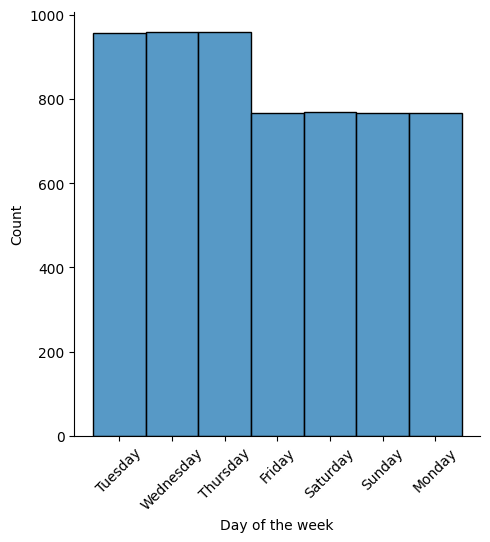

In [72]:
plot= sns.displot(dfTraffic, x='Day of the week')
plot.set_xticklabels(rotation=45)

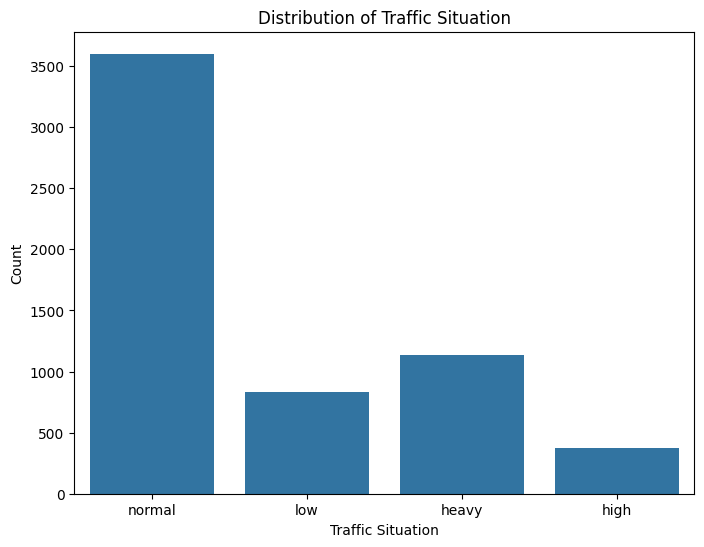

In [73]:
# رسم توزيع Traffic Situation
plt.figure(figsize=(8, 6))
sns.countplot(x='Traffic Situation', data=dfTraffic)
plt.title('Distribution of Traffic Situation')
plt.xlabel('Traffic Situation')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Total', ylabel='Count'>

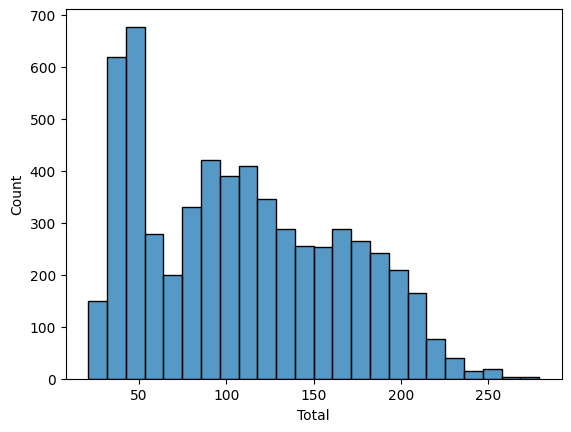

In [74]:
sns.histplot(dfTraffic['Total'])

In [75]:
dfTraffic.columns

Index(['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [76]:
dfTraffic.index

DatetimeIndex(['2024-08-26 00:00:00', '2024-08-26 00:15:00',
               '2024-08-26 00:30:00', '2024-08-26 00:45:00',
               '2024-08-26 01:00:00', '2024-08-26 01:15:00',
               '2024-08-26 01:30:00', '2024-08-26 01:45:00',
               '2024-08-26 02:00:00', '2024-08-26 02:15:00',
               ...
               '2024-08-26 21:30:00', '2024-08-26 21:45:00',
               '2024-08-26 22:00:00', '2024-08-26 22:15:00',
               '2024-08-26 22:30:00', '2024-08-26 22:45:00',
               '2024-08-26 23:00:00', '2024-08-26 23:15:00',
               '2024-08-26 23:30:00', '2024-08-26 23:45:00'],
              dtype='datetime64[ns]', name='Time', length=5941, freq=None)

<Figure size 1000x600 with 0 Axes>

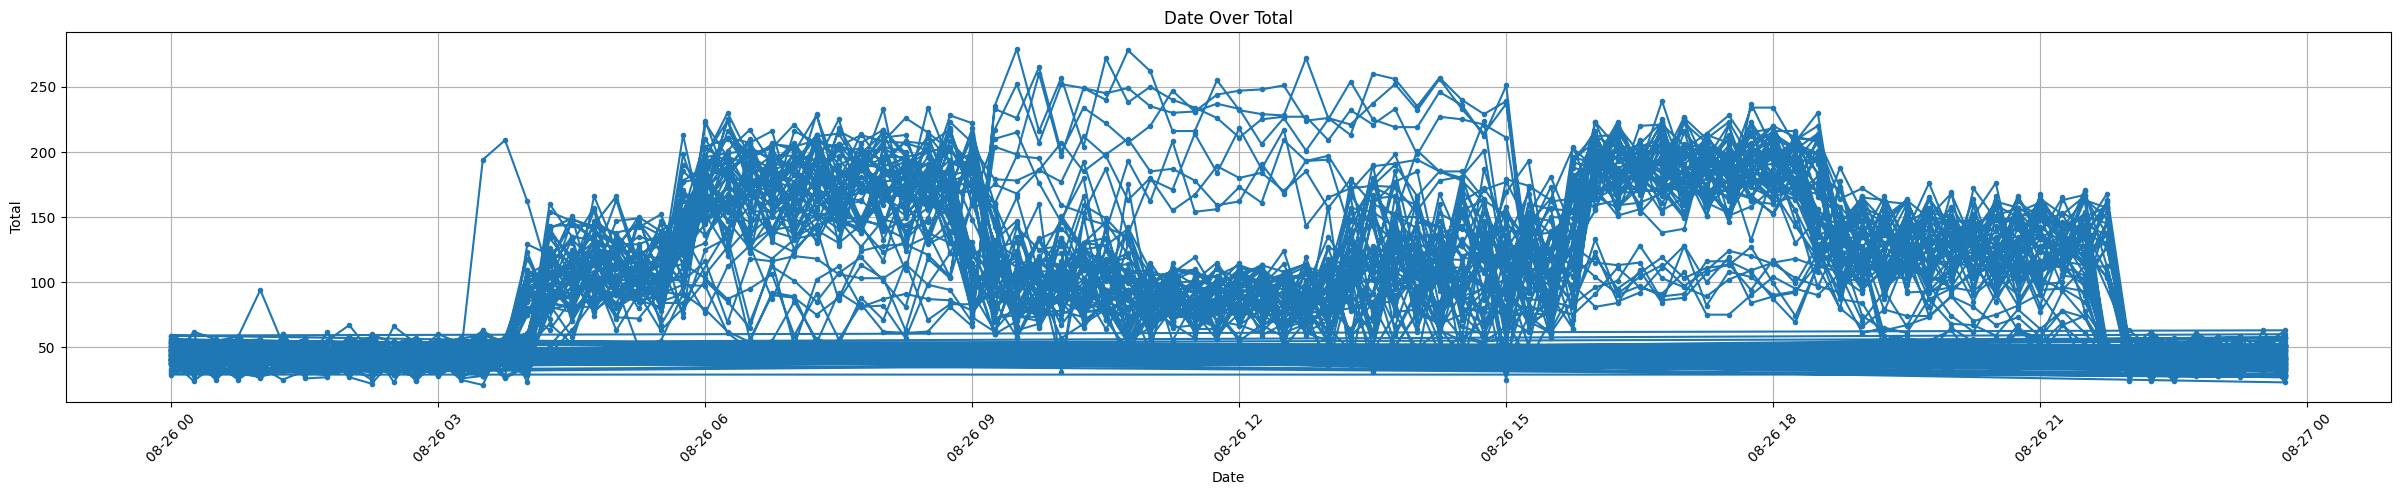

In [77]:
# Line Chart of Total Over DateTime

plt.figure(figsize=(10, 6))
plt.figure().set_figwidth(30)

plt.plot(dfTraffic.index, dfTraffic['Total'], marker='.')

plt.title('Date Over Total')
plt.xlabel('Date')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

The line chart shows the Cyclic Trend

**Correlation**

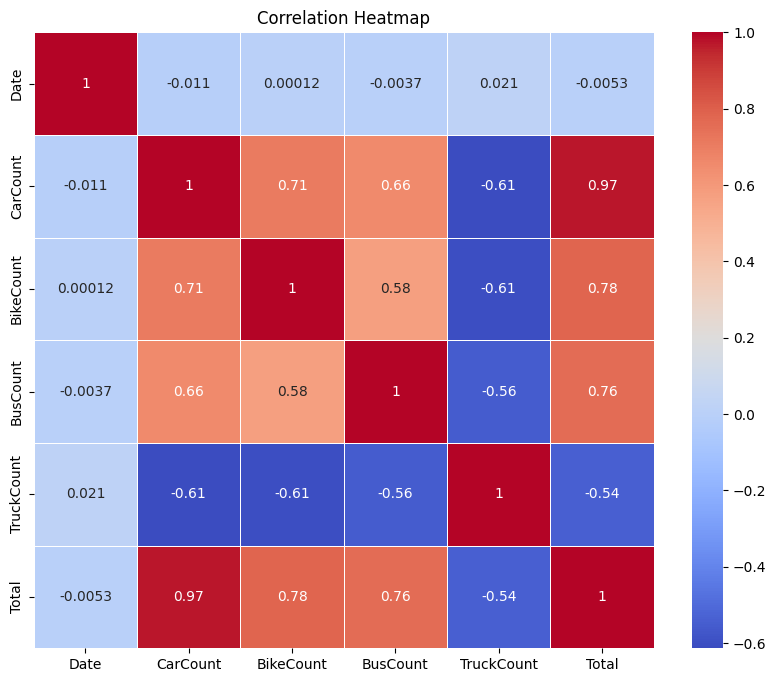

Total         1.000000
CarCount      0.971432
BikeCount     0.781636
BusCount      0.758380
Date         -0.005306
TruckCount   -0.544127
Name: Total, dtype: float64


In [78]:
selected_columns = ['Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']

correlation_matrix = dfTraffic[selected_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Get the correlation values for 'Traffic Situation'
Traffic_corr = correlation_matrix['Total'].sort_values(ascending=False)
print(Traffic_corr)

**Check Outliers and handle them**

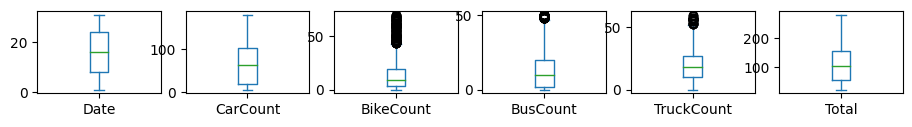

In [79]:
dfTraffic.plot(kind='box', subplots=True, layout=(8,8), figsize=(15, 10))
plt.show()

In [80]:
#handle outliers
def remove_outliers(TRAFFIC, column):
    Q1 = dfTraffic[column].quantile(0.25)
    Q3 = dfTraffic[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return dfTraffic[(dfTraffic[column] >= lower_bound) & (dfTraffic[column] <= upper_bound)]

dfTraffic = remove_outliers(dfTraffic,"BikeCount")
dfTraffic = remove_outliers(dfTraffic,"BusCount")
dfTraffic = remove_outliers(dfTraffic,"TruckCount")
dfTraffic = remove_outliers(dfTraffic,"Total")

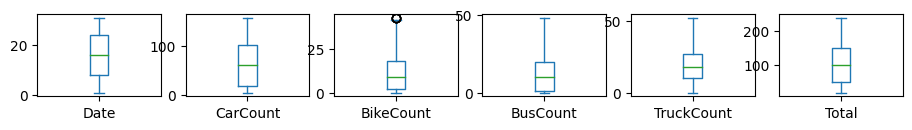

In [81]:
dfTraffic.plot(kind='box', subplots=True, layout=(8,8), figsize=(15, 10))
plt.show()

<Axes: xlabel='Time'>

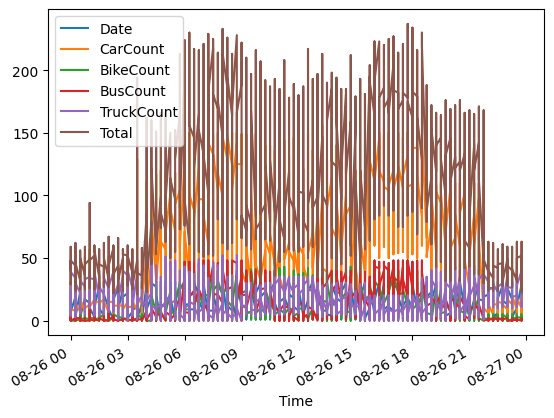

In [82]:
dfTraffic.plot()

In [83]:
dfTraffic.head()

Date Day of the week  CarCount  BikeCount  BusCount  \
Time                                                                       
2024-08-26 00:00:00    10         Tuesday        13          2         2   
2024-08-26 00:15:00    10         Tuesday        14          1         1   
2024-08-26 00:30:00    10         Tuesday        10          2         2   
2024-08-26 00:45:00    10         Tuesday        10          2         2   
2024-08-26 01:00:00    10         Tuesday        11          2         1   

                     TruckCount  Total Traffic Situation  
Time                                                      
2024-08-26 00:00:00          24     41            normal  
2024-08-26 00:15:00          36     52            normal  
2024-08-26 00:30:00          32     46            normal  
2024-08-26 00:45:00          36     50            normal  
2024-08-26 01:00:00          34     48            normal

  **Choosing two columns from the dataset to apply the model:**

In [84]:
#Cretae new Df contain two feautres
new_TRAFFIC1 = dfTraffic[['Date', 'Total']]
new_TRAFFIC1.head()

Date  Total
Time                            
2024-08-26 00:00:00    10     41
2024-08-26 00:15:00    10     52
2024-08-26 00:30:00    10     46
2024-08-26 00:45:00    10     50
2024-08-26 01:00:00    10     48

In [85]:
new_TRAFFIC1.shape

(5764, 2)

In [86]:
new_TRAFFIC1.index

DatetimeIndex(['2024-08-26 00:00:00', '2024-08-26 00:15:00',
               '2024-08-26 00:30:00', '2024-08-26 00:45:00',
               '2024-08-26 01:00:00', '2024-08-26 01:15:00',
               '2024-08-26 01:30:00', '2024-08-26 01:45:00',
               '2024-08-26 02:00:00', '2024-08-26 02:15:00',
               ...
               '2024-08-26 21:30:00', '2024-08-26 21:45:00',
               '2024-08-26 22:00:00', '2024-08-26 22:15:00',
               '2024-08-26 22:30:00', '2024-08-26 22:45:00',
               '2024-08-26 23:00:00', '2024-08-26 23:15:00',
               '2024-08-26 23:30:00', '2024-08-26 23:45:00'],
              dtype='datetime64[ns]', name='Time', length=5764, freq=None)

<Axes: xlabel='Time'>

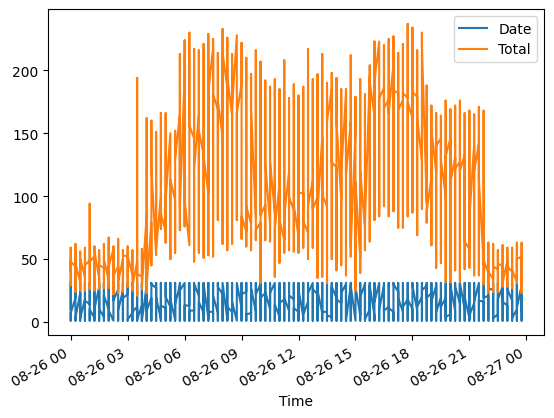

In [87]:
new_TRAFFIC1.plot()

In [88]:
new_TRAFFIC1.sort_index(inplace=True)

<ipython-input-88-80d37cb030dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_TRAFFIC1.sort_index(inplace=True)


# Split the data

In [147]:
'''train = new_TRAFFIC1.loc['2024-08-26 00:00:00':'2024-08-26 16:59:00'] # ( 12am - 4pm )16 hours for Train
val = new_TRAFFIC1.loc['2024-08-26 17:00:00':'2024-08-26 20:59:00'] # (5pm - 8pm ) 3 hours for Validation
test =new_TRAFFIC1.loc['2024-08-26 21:00:00':'2024-08-26 23:59:00'] # ( 9pm - 12am)  Testing'''

# Spliting the data into 80% for training and 10% for testing and 10% for validation
train_len = int(len(new_TRAFFIC1) * 0.8)
val_len = int(len(new_TRAFFIC1) * 0.1)

# Split the data
train = new_TRAFFIC1.iloc[:train_len]
val = new_TRAFFIC1.iloc[train_len:train_len + val_len]
test = new_TRAFFIC1.iloc[train_len + val_len:]

In [148]:
# split train into trainX and trainY
from tensorflow.keras.utils import timeseries_dataset_from_array

window_size  = 12    # take 12 hours to predict the next day

train_Xy = timeseries_dataset_from_array(train, targets=train[window_size:], sequence_length= window_size)
test_Xy =timeseries_dataset_from_array(test, targets= test[window_size:], sequence_length= window_size)
val_Xy =timeseries_dataset_from_array(val, targets= val[window_size:], sequence_length= window_size)

In [149]:
test_X, test_y = next(iter(test_Xy))

# Build SimpleRNN model

Recurrent Neural Networks (RNNs) are a class of neural networks that are powerful for modeling sequence data such as time series or natural language. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being dependent on the previous computations. Unlike traditional neural networks, RNNs have a memory that captures information about what has been calculated so far, effectively building a sense of time into the model.

In [150]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#build model
modelRNN = Sequential([

    SimpleRNN(units=100, activation='tanh', return_sequences=True),  # الطبقة المخفية الأولى
    SimpleRNN(units=100, activation='tanh', return_sequences=True),# الطبقة المخفية الثانية
    SimpleRNN(units=100, activation='tanh', return_sequences=True), # الطبقة الثالثة
    SimpleRNN(units=100, activation='tanh'),  #الطبقة الرابعة

    Dense(units=1, activation='relu')  #output layer
])

modelRNN.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Simple_history= modelRNN.fit(train_Xy, validation_data=val_Xy, epochs=100, callbacks=[early_stopping])  #


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 4125.2920 - mae: 43.1452 - val_loss: 5844.3550 - val_mae: 55.6065
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3585.9905 - mae: 37.2071 - val_loss: 5496.9521 - val_mae: 53.9958
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3374.3765 - mae: 35.7117 - val_loss: 5195.1226 - val_mae: 52.8075
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3196.2307 - mae: 34.6428 - val_loss: 4927.9326 - val_mae: 52.0009
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3045.9949 - mae: 33.9362 - val_loss: 4691.9004 - val_mae: 51.5338
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2920.2441 - mae: 33.5446 - val_loss: 4483.5195 - val_mae: 51.3346
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2815.9958 - mae: 33.4587 - val_loss: 4299.9229 - val_mae: 51.3228
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2730.6934 - mae: 33.6085 - val_loss: 4138.6157 - val_mae

**Evaluation**

In [169]:
modelRNN.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_16 (SimpleRNN)            │ (None, None, 100)           │          10,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_18 (SimpleRNN)            │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_19 (SimpleRNN)            │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,105 (828.54 KB)

 Trainable params: 70,701 (276.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,404 (552.36 KB)

In [151]:
modelRNN.evaluate(test_Xy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 1805.4929 - mae: 38.2589


[1644.3170166015625, 36.664493560791016]

**Predict SimpleRNN:**

In [152]:
predict_RNN = modelRNN.predict(test_Xy)

predict_RNN

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


array([[64.101555],
       [64.10126 ],
       [64.10138 ],
       [64.10148 ],
       [64.10156 ],
       [64.10152 ],
       [64.10156 ],
       [64.10159 ],
       [64.10104 ],
       [64.100525],
       [64.10127 ],
       [64.09939 ],
       [64.10025 ],
       [64.10052 ],
       [64.10107 ],
       [64.09634 ],
       [64.09627 ],
       [64.09276 ],
       [64.09756 ],
       [64.09825 ],
       [64.09739 ],
       [64.10008 ],
       [64.09446 ],
       [64.09209 ],
       [64.097244],
       [64.10071 ],
       [64.101105],
       [64.10144 ],
       [64.09893 ],
       [64.095924],
       [64.09284 ],
       [64.09299 ],
       [64.091965],
       [64.09829 ],
       [64.09467 ],
       [64.0988  ],
       [64.101105],
       [64.10149 ],
       [64.10107 ],
       [64.10072 ],
       [64.10124 ],
       [64.09705 ],
       [64.09777 ],
       [64.093445],
       [64.09195 ],
       [64.09226 ],
       [64.091995],
       [64.09169 ],
       [64.09718 ],
       [64.10089 ],


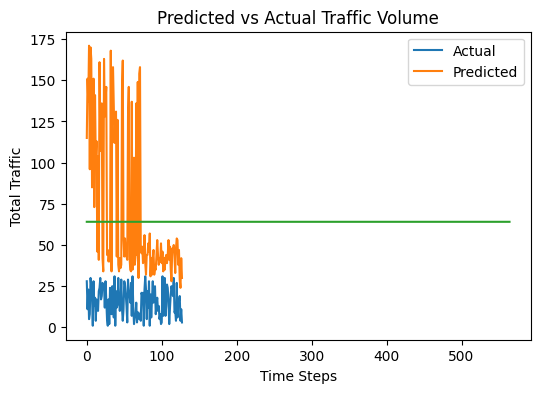

In [153]:
plt.figure(figsize=(6, 4))
plt.plot(test_y, label='Actual')
plt.plot(predict_RNN, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Total Traffic')
plt.title('Predicted vs Actual Traffic Volume')
plt.legend(['Actual','Predicted'])
plt.show()

## **Simple RNN Model plot**

<Axes: >

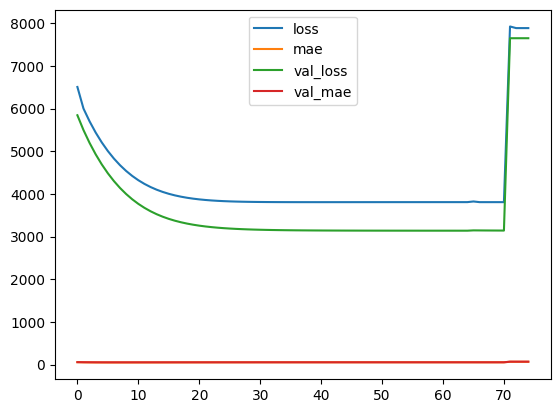

In [154]:
pd.DataFrame(Simple_history.history).plot()

**Save RNN Model**

In [95]:
#Save the model

modelRNN.save('SimpleRNN_Model.keras')

# **GRU Model**

A GRU is a type of recurrent neural network (RNN) designed to capture dependencies in sequential data. It uses two gates: an update gate and a reset gate, to manage the flow of information, making it more efficient and effective than standard RNNs. GRUs are used in applications like natural language processing, time series analysis, and speech recognition.

In [155]:
from tensorflow.keras.callbacks import EarlyStopping

# Build the GRU model
GRU_model = Sequential([
    GRU(units=50,activation='tanh', return_sequences=True),
    GRU(units=50, activation='tanh',return_sequences=True),
    GRU(units=50, activation='tanh'),
    Dense(units=1)
])

# Compile the model
GRU_model.compile(optimizer='adam', loss='mse',metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
GRUhistory = GRU_model.fit(train_Xy, epochs=100, batch_size=32, validation_data=val_Xy, callbacks=[early_stopping])



Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4480.1069 - mae: 45.8538 - val_loss: 6394.0488 - val_mae: 58.6575
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3977.6025 - mae: 40.3161 - val_loss: 6162.5757 - val_mae: 57.3097
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3832.3125 - mae: 39.0627 - val_loss: 5966.2134 - val_mae: 56.2323
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3705.0825 - mae: 38.0246 - val_loss: 5785.6938 - val_mae: 55.3186
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3589.5437 - mae: 37.1337 - val_loss: 5617.4253 - val_mae: 54.5278
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3483.4631 - mae: 36.3672 - val_loss: 5459.5107 - val_mae: 53.8335
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3385.6428 - mae: 35.7075 - val_loss: 5310.8589 - val_mae: 53.2352
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3295.3218 - mae: 35.1430 - val_loss: 5170.7275 - val_mae: 

In [170]:
GRU_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, None, 50)            │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, None, 50)            │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,255 (454.12 KB)

 Trainable params: 38,751 (151.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,504 (302.75 KB)

**Evaluating the model**

In [156]:
# Evaluate the model on the test data
test_loss = GRU_model.evaluate(test_Xy)
print("Test Loss:", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 870.8423 - mae: 21.2145 
Test Loss: [582.3692626953125, 17.564390182495117]


In [157]:
predict_GRU = GRU_model.predict(test_Xy)

predict_GRU

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[66.69835 ],
       [66.661316],
       [66.70147 ],
       [66.7104  ],
       [66.71658 ],
       [66.71529 ],
       [66.71474 ],
       [66.715416],
       [66.696014],
       [66.71357 ],
       [66.71365 ],
       [66.561844],
       [66.6922  ],
       [66.70638 ],
       [66.70677 ],
       [63.723656],
       [63.774216],
       [61.44945 ],
       [64.3286  ],
       [62.85536 ],
       [62.69454 ],
       [63.861076],
       [60.86192 ],
       [56.76712 ],
       [61.474743],
       [62.92191 ],
       [63.181274],
       [64.30423 ],
       [61.69918 ],
       [60.609028],
       [57.49943 ],
       [54.567856],
       [48.695274],
       [58.847954],
       [56.95716 ],
       [61.656307],
       [63.147488],
       [63.917492],
       [61.44246 ],
       [62.472992],
       [62.98705 ],
       [61.20595 ],
       [62.934475],
       [59.657906],
       [57.461308],
       [55.17509 ],
       [51.910168],
       [44.376797],
       [50.945637],
       [57.958637],


## **GRU Model plot**

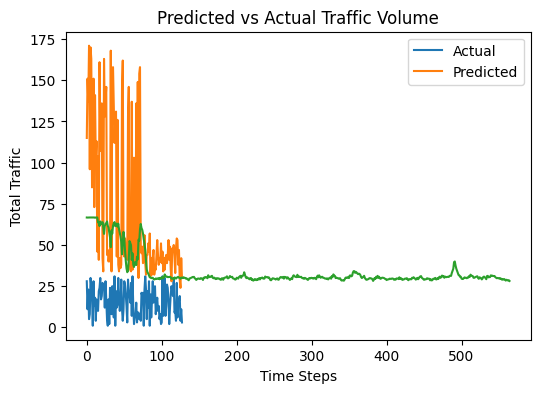

In [159]:
plt.figure(figsize=(6, 4))
plt.plot(test_y, label='Actual')
plt.plot(predict_GRU, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Total Traffic')
plt.title('Predicted vs Actual Traffic Volume')
plt.legend(['Actual','Predicted'])
plt.show()

<Axes: >

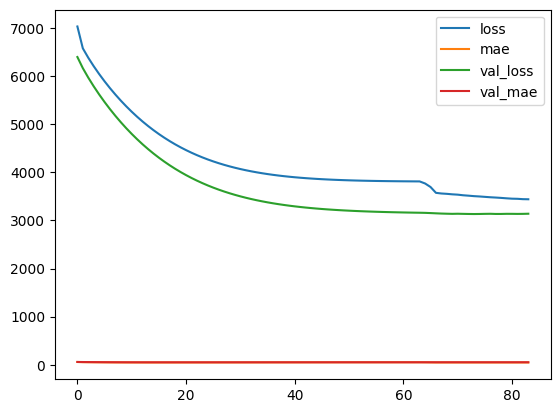

In [160]:
pd.DataFrame(GRUhistory.history).plot()

In [113]:
#Save the model

GRU_model.save('GRU_Model.keras')

## **LSTM Model**

LSTM is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. Unlike standard RNNs, LSTMs use gates (input, forget, and output gates) to control the flow of information, allowing them to remember important information over long sequences. This makes LSTMs effective for tasks like natural language processing, time series forecasting, and speech recognition.

In [162]:
#LSTM
LSTM_model = Sequential( [LSTM(units=100, activation='tanh', return_sequences=True), #1st hidden layer
                     LSTM(units=100, activation='tanh', return_sequences=True), #2nd hidden layer
                     LSTM(units=100, activation='tanh'),  #3rd hidden layer
    Dense(units=1, activation='relu')]) #output layer

In [163]:
# Compile

LSTM_model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']
)

In [171]:
LSTM_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, None, 100)           │          41,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,305 (2.31 MB)

 Trainable params: 202,101 (789.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 404,204 (1.54 MB)

In [164]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


#Fit
LSTMhistory = LSTM_model.fit(train_Xy, validation_data=val_Xy, epochs=100, callbacks=[early_stopping])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4300.5825 - mae: 44.6042 - val_loss: 5973.7720 - val_mae: 56.2734
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3658.4983 - mae: 37.7852 - val_loss: 5588.2046 - val_mae: 54.3960
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3428.3215 - mae: 36.0740 - val_loss: 5272.7178 - val_mae: 53.0869
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3241.4082 - mae: 34.8931 - val_loss: 4997.9077 - val_mae: 52.1833
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3085.0854 - mae: 34.0978 - val_loss: 4756.0522 - val_mae: 51.6328
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2954.2393 - mae: 33.6260 - val_loss: 4542.7109 - val_mae: 51.3696
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2845.4290 - mae: 33.4522 - val_loss: 4354.6157 - val_mae: 51.3186
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2755.9011 - mae: 33.5494 - val_loss: 4189.0859 - val_mae: 

**Evaluating the model**

In [165]:
# Evaluate the model on the test data
test_loss = LSTM_model.evaluate(test_Xy)
print("Test Loss:", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 885.1927 - mae: 20.6899 
Test Loss: [588.3538208007812, 17.251462936401367]


In [166]:
predict_LSTM = LSTM_model.predict(test_Xy)
predict_LSTM

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


array([[67.27491 ],
       [67.27476 ],
       [67.27494 ],
       [67.27493 ],
       [67.27502 ],
       [67.274895],
       [67.274994],
       [67.275   ],
       [67.27476 ],
       [67.274925],
       [67.27495 ],
       [67.27459 ],
       [67.2749  ],
       [67.274826],
       [67.27483 ],
       [67.27023 ],
       [67.27362 ],
       [67.23449 ],
       [67.269066],
       [67.2701  ],
       [67.27051 ],
       [67.27118 ],
       [67.00064 ],
       [43.314907],
       [65.4077  ],
       [66.98428 ],
       [67.194626],
       [67.246506],
       [66.12514 ],
       [40.23571 ],
       [30.69174 ],
       [30.081339],
       [29.884422],
       [52.692806],
       [32.246433],
       [58.725628],
       [65.204185],
       [66.57914 ],
       [66.97055 ],
       [67.17506 ],
       [67.24555 ],
       [65.43093 ],
       [67.24086 ],
       [65.86599 ],
       [40.146168],
       [31.59063 ],
       [30.224724],
       [29.928598],
       [49.993206],
       [61.915436],


LSTM MODEL PLOT

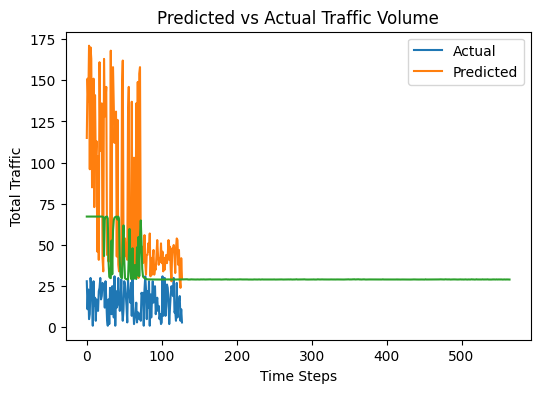

In [167]:
plt.figure(figsize=(6, 4))
plt.plot(test_y, label='Actual')
plt.plot(predict_LSTM, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Total Traffic')
plt.title('Predicted vs Actual Traffic Volume')
plt.legend(['Actual','Predicted'])
plt.show()

<Axes: >

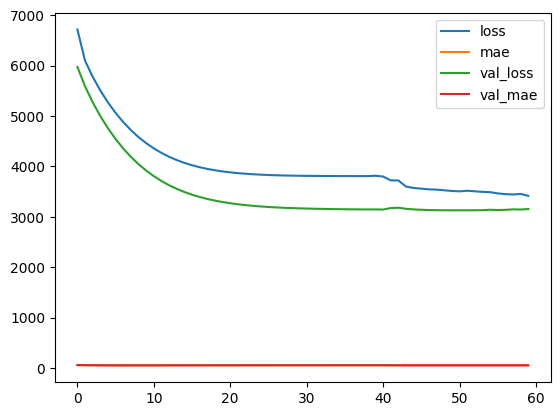

In [168]:
pd.DataFrame(LSTMhistory.history).plot()

In [ ]:
#Save the model

LSTM_model.save('LSTM_Model.keras')